## Importing the libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing and preprocessing the data


In [2]:
def importdata():
    data=pd.read_csv('data.csv')
    # Removing the unneeded column
    data.drop(['Unnamed: 0'],axis=1,inplace=True)
    # printing the dataset observations
    print('All the data:')
    display(data.head())
    # Statistical Summary
    print('Statistical Summary:')
    display(data.describe())
    # Get a new clean dataframe
    obj_data = data.select_dtypes(include=['object']).copy()
    obj_data["area_type"] = obj_data["area_type"].astype('category')
    # Label Encoding
    obj_data["area_type_cat"] = obj_data["area_type"].cat.codes
    data["area_type_cat"] = obj_data["area_type_cat"]
    data['price in rupees']=data['price in rupees']/1000
    print('Rearrange Data after Label Encoding:')
    display(data.head())
    display(data.describe())
    return data

## Classification Node class. Stores the specific information of the Node

In [3]:
class Node_cls():
    def __init__(self, feature_idx=None, threshold=None, 
                 left=None, right=None, gini=None, value=None):

        # decision node
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gini = gini
        
        # leaf node
        self.value = value

## Regression Node class. Stores the specific information of the Node

In [4]:
class Node_reg():
    def __init__(self, feature_idx=None, threshold=None, 
                 left=None, right=None, squared_error=None, value=None):

        # decision node
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.squared_error = squared_error
        
        # leaf node
        self.value = value

#### Decision tree Node stores gini calculation in it while the regression tree Node stores the squared error

## Decision Tree Classifier Class 

#### Contains the needed functions for perform classification

In [5]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        
        self.root = None     
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            bestsplit = self.get_best_split(dataset, num_samples, num_features)
            if bestsplit["gini"]>0:
                left_subtree = self.build_tree(bestsplit["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(bestsplit["dataset_right"], curr_depth+1)
                return Node_cls(bestsplit["feature_idx"], bestsplit["threshold"], 
                            left_subtree, right_subtree, bestsplit["gini"])        
        leaf_value = self.calculate_leaf_value(Y)
        return Node_cls(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        
        bestsplit = {}
        max_gini = -float("inf")
        
        for feature_idx in range(num_features):
            feature_values = dataset[:, feature_idx]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split_tree(dataset, feature_idx, threshold)
                if len(dataset_right)>0 and len(dataset_left)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_gini = self.gini_impurity(y, left_y, right_y)
                    if curr_gini>max_gini:
                        bestsplit["gini"] = curr_gini                   
                        bestsplit["dataset_left"] = dataset_left
                        bestsplit["dataset_right"] = dataset_right
                        bestsplit["threshold"] = threshold
                        bestsplit["feature_idx"] = feature_idx
                        max_gini = curr_gini
                        
        return bestsplit
    
    def split_tree(self, dataset, feature_idx, threshold):
        
        dataset_right = np.array([row for row in dataset if row[feature_idx]>threshold])
        dataset_left = np.array([row for row in dataset if row[feature_idx]<=threshold])
        return dataset_left, dataset_right
    
    def gini_impurity(self, parent, l_child, r_child):
        
        weight_r = len(r_child) / len(parent)
        weight_l = len(l_child) / len(parent)
        gain = self.gini_idx(parent) - (weight_l*self.gini_idx(l_child) 
                                          + weight_r*self.gini_idx(r_child))
        return gain
    
    def gini_idx(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root
        if tree.value is not None:
            print("value: [%.2f]" % (tree.value))
        else:
            print("(feature_"+str(tree.feature_idx),")", "<=", 
                  tree.threshold,"gini impurity =","%.2f" % (tree.gini))
            print("%s" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%s" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_idx]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

## Decision Tree Regressor Class 

#### Contains the needed functions for perform regression

In [6]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=3, max_depth=3):

        self.root = None      
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        bestsplit = {}
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            bestsplit = self.get_best_split(dataset, num_samples, num_features)
            if bestsplit["squared_error"]>0:
                left_subtree = self.build_tree(bestsplit["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(bestsplit["dataset_right"], curr_depth+1)
                return Node_reg(bestsplit["feature_idx"], bestsplit["threshold"], 
                            left_subtree, right_subtree, bestsplit["squared_error"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node_reg(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        
        bestsplit = {}
        max_squared_error = -float("inf")
        for feature_idx in range(num_features):
            feature_values = dataset[:, feature_idx]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split_tree(dataset, feature_idx, threshold)
                if len(dataset_right)>0 and len(dataset_left)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_squared_error = self.variance_reduction(y, left_y, right_y)
                    if curr_squared_error>max_squared_error:
                        bestsplit["squared_error"] = curr_squared_error
                        bestsplit["dataset_left"] = dataset_left
                        bestsplit["dataset_right"] = dataset_right
                        bestsplit["threshold"] = threshold
                        bestsplit["feature_idx"] = feature_idx
                        max_squared_error = curr_squared_error
                        
        return bestsplit
    
    def split_tree(self, dataset, feature_idx, threshold):
        
        dataset_right = np.array([row for row in dataset if row[feature_idx]>threshold])
        dataset_left = np.array([row for row in dataset if row[feature_idx]<=threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        
        weight_r = len(r_child) / len(parent)
        weight_l = len(l_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root
        if tree.value is not None:
            print("value: [%.2f]" % (tree.value))
        else:
            print("(feature_"+str(tree.feature_idx),")", "<=", 
                  tree.threshold,"squared error=","%.2f" % (tree.squared_error))
            print("%s" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%s" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_idx]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

## Ada-Boost Classifier


#### Using our custom classifier to perform clasification

In [7]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.threshold = None
        self.feature_idx = None
        self.alpha = None
        
    def predict(self,X):
        n_samples = X.shape[0]
        X_c = X[:,self.feature_idx]
        preds = np.ones(n_samples)        
        if self.polarity ==1:
            preds[X_c < self.threshold] = 0
        else:
            preds[X_c > self.threshold] = 0           
        return preds
      
class myAdaBoost:
    def __init__(self,n_clf=3):
        self.n_clf = n_clf

    def convert(self,arr):
      nr = np.array
      for i in arr:
        nr.append(i[0])
      return nr
        
    def fit(self,X,y):
        n_samples,n_features = X.shape
        w = np.full(n_samples, (1/n_samples))        
        self.clfs=[]
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float('inf')
            for feat in range(n_features):
                X_c = X[:,feat]
                thresholds=np.unique(X_c)
                for threshold in thresholds:
                    p=1
                    preds=np.ones(n_samples)
                    preds[X_c<threshold]=0                   
                    misclassified = w[y[0]!=preds]
                    error=sum(misclassified)   
                    if error >0.5:
                        p=0
                        error=1-error
                    if error<min_error:
                        min_error=error
                        clf.threshold=threshold
                        clf.feature_idx=feat
                        clf.polarity=p
            EPS=1e-10
            clf.alpha=0.5*np.log((1.0-min_error+EPS)/(min_error+EPS))
            preds = clf.predict(X)
            nr = []
            for i in y:
              nr.append(float(i[0]))
            w *= np.exp(-clf.alpha*nr[0]*preds[0])
            w/=np.sum(w)
            self.clfs.append(clf)
            
    def predict(self,X):
        clf_preds = [clf.alpha*clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds,axis=0)
        y_pred = np.sign(y_pred)
        return y_pred    
    
def accuracy(y_true, y_pred):
    accuracy = 1 - ( np.sum(y_true) / len(y_pred))
    return accuracy


## Rearrange the columns regard to target for the classification and regresion 
### data_cls - for classification
### data_reg - for regression

#### area_type_cat - is a column that represents the dataset's area_type in numaric values (1 - P , 0 - B)

In [8]:
data=importdata()
data_cls = data.reindex(columns=['availability','bedrooms','total_sqft','bath','balcony','ranked','price in rupees','area_type_cat'])
data_reg = data.reindex(columns=['area_type_cat','availability','bedrooms','total_sqft','bath','balcony','ranked','price in rupees'])

All the data:


,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,B,1,3.0,1655.0,3.0,1.0,134,10800000.0
1,B,1,2.0,1102.0,2.0,1.0,134,4800000.0
2,B,0,2.0,1112.0,2.0,1.0,242,8800000.0
3,B,1,3.0,1450.0,3.0,3.0,335,5100000.0
4,B,1,2.0,1010.0,2.0,1.0,261,4100000.0


Statistical Summary:


,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
count,12563.000000,12563.000000,1.256300e+04,12563.000000,12563.000000,12563.000000,1.256300e+04
mean,0.798535,2.741145,1.794519e+03,2.617607,1.602165,236.386054,1.063007e+07
std,0.401110,1.204731,1.470231e+04,1.221164,0.804165,120.749788,1.322695e+07
min,0.000000,1.000000,2.500000e+02,1.000000,0.000000,1.000000,8.000000e+05
25%,1.000000,2.000000,1.100000e+03,2.000000,1.000000,134.000000,4.950000e+06
50%,1.000000,3.000000,1.260000e+03,2.000000,2.000000,226.000000,7.000000e+06
75%,1.000000,3.000000,1.641500e+03,3.000000,2.000000,335.000000,1.150000e+07
max,1.000000,43.000000,1.306800e+06,40.000000,3.000000,504.000000,2.912000e+08


Rearrange Data after Label Encoding:


,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees,area_type_cat
0,B,1,3.0,1655.0,3.0,1.0,134,10800.0,0
1,B,1,2.0,1102.0,2.0,1.0,134,4800.0,0
2,B,0,2.0,1112.0,2.0,1.0,242,8800.0,0
3,B,1,3.0,1450.0,3.0,3.0,335,5100.0,0
4,B,1,2.0,1010.0,2.0,1.0,261,4100.0,0


,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees,area_type_cat
count,12563.000000,12563.000000,1.256300e+04,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000
mean,0.798535,2.741145,1.794519e+03,2.617607,1.602165,236.386054,10630.074027,0.146064
std,0.401110,1.204731,1.470231e+04,1.221164,0.804165,120.749788,13226.952461,0.353184
min,0.000000,1.000000,2.500000e+02,1.000000,0.000000,1.000000,800.000000,0.000000
25%,1.000000,2.000000,1.100000e+03,2.000000,1.000000,134.000000,4950.000000,0.000000
50%,1.000000,3.000000,1.260000e+03,2.000000,2.000000,226.000000,7000.000000,0.000000
75%,1.000000,3.000000,1.641500e+03,3.000000,2.000000,335.000000,11500.000000,0.000000
max,1.000000,43.000000,1.306800e+06,40.000000,3.000000,504.000000,291200.000000,1.000000


# 1 - Classification - Predicting the area_type

## Split dataset into training set, validation set and test set

In [9]:
data_cls_train = data_cls.iloc[:8040]
data_cls_valid = data_cls.iloc[8040:10050]
data_cls_test = data_cls.iloc[10051::]
X_cls_train = data_cls_train.iloc[:, :-1].values
X_cls_valid = data_cls_valid.iloc[:, :-1].values
X_cls_test = data_cls_test.iloc[:, :-1].values
Y_cls_train = data_cls_train.iloc[:, -1].values.reshape(-1,1)
Y_cls_valid = data_cls_valid.iloc[:, -1].values.reshape(-1,1)
Y_cls_test = data_cls_test.iloc[:, -1].values.reshape(-1,1)

# Training/Validating

## 1.1 Training the Classifier model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the classifier was set to 2 

In [10]:
import timeit
# measuring runtime
start = timeit.default_timer()
# define model
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=2)
# fit estimator
classifier.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
clf_imp_runtime_1 = stop - start 
print('Time: ', clf_imp_runtime_1)
print('Our Decision Tree Classifier:')
classifier.print_tree()

Time:  53.3559704
Our Decision Tree Classifier:
(feature_1 ) <= 3.0 gini impurity = 0.06
 (feature_4 ) <= 0.0 gini impurity = 0.01
  (feature_6 ) <= 6500.0 gini impurity = 0.05
    value: [0.00]
    value: [1.00]
  (feature_6 ) <= 14200.0 gini impurity = 0.00
    value: [0.00]
    value: [0.00]
 (feature_2 ) <= 1660.0 gini impurity = 0.12
  (feature_6 ) <= 7300.0 gini impurity = 0.01
    value: [1.00]
    value: [1.00]
  (feature_6 ) <= 24900.0 gini impurity = 0.05
    value: [0.00]
    value: [1.00]


### Predicting Vlaidation labels and calculating the accuracy with max_depth = 2 as hyper parameter

In [11]:
Y_cls_pred = classifier.predict(X_cls_valid) 
from sklearn.metrics import accuracy_score
print('Accuracy = %.4f' % (accuracy_score(Y_cls_valid, Y_cls_pred)))

Accuracy = 0.8955


## 1.2 Training the Classifier model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the classifier was set to 3 

In [12]:
import timeit
# measuring runtime
start = timeit.default_timer()
# define model
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
# fit estimator
classifier.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
clf_imp_runtime_2 = stop - start
print('Time: ', stop - start)
print('Our Decision Tree Classifier:')
classifier.print_tree()

Time:  65.0509836
Our Decision Tree Classifier:
(feature_1 ) <= 3.0 gini impurity = 0.06
 (feature_4 ) <= 0.0 gini impurity = 0.01
  (feature_6 ) <= 6500.0 gini impurity = 0.05
    (feature_6 ) <= 5100.0 gini impurity = 0.01
        value: [0.00]
        value: [0.00]
    (feature_5 ) <= 266.0 gini impurity = 0.05
        value: [0.00]
        value: [1.00]
  (feature_6 ) <= 14200.0 gini impurity = 0.00
    (feature_2 ) <= 600.0 gini impurity = 0.00
        value: [0.00]
        value: [0.00]
    (feature_2 ) <= 1550.0 gini impurity = 0.04
        value: [1.00]
        value: [0.00]
 (feature_2 ) <= 1660.0 gini impurity = 0.12
  (feature_6 ) <= 7300.0 gini impurity = 0.01
    (feature_2 ) <= 810.0 gini impurity = 0.11
        value: [1.00]
        value: [0.00]
    (feature_2 ) <= 499.0 gini impurity = 0.00
        value: [0.00]
        value: [1.00]
  (feature_6 ) <= 24900.0 gini impurity = 0.05
    (feature_2 ) <= 2400.0 gini impurity = 0.02
        value: [0.00]
        value: [0.00

### Predicting Vlaidation labels and calculating the accuracy with max_depth = 3 as hyper parameter

In [13]:
Y_cls_pred = classifier.predict(X_cls_valid) 
from sklearn.metrics import accuracy_score
print('Accuracy = %.4f' % (accuracy_score(Y_cls_valid, Y_cls_pred)))

Accuracy = 0.9010


## 1.3 Training the Classifier model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the classifier was set to 5 

In [14]:
import timeit
# measuring runtime
start = timeit.default_timer()
# define model
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
# fit estimator
classifier.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
clf_imp_runtime_3 = stop - start
print('Time: ', clf_imp_runtime_3)
print('Our Decision Tree Classifier:')
classifier.print_tree()

Time:  88.614636
Our Decision Tree Classifier:
(feature_1 ) <= 3.0 gini impurity = 0.06
 (feature_4 ) <= 0.0 gini impurity = 0.01
  (feature_6 ) <= 6500.0 gini impurity = 0.05
    (feature_6 ) <= 5100.0 gini impurity = 0.01
        (feature_5 ) <= 493.0 gini impurity = 0.02
                (feature_6 ) <= 1050.0 gini impurity = 0.01
                                value: [1.00]
                                value: [0.00]
                value: [1.00]
        (feature_5 ) <= 226.0 gini impurity = 0.04
                (feature_2 ) <= 600.0 gini impurity = 0.12
                                value: [1.00]
                                value: [0.00]
                (feature_2 ) <= 900.0 gini impurity = 0.04
                                value: [1.00]
                                value: [0.00]
    (feature_5 ) <= 266.0 gini impurity = 0.05
        (feature_2 ) <= 3200.0 gini impurity = 0.02
                (feature_2 ) <= 1200.0 gini impurity = 0.03
                               

### Predicting Vlaidation labels and calculating the accuracy with max_depth = 5 as hyper parameter

In [15]:
Y_cls_pred = classifier.predict(X_cls_valid) 
from sklearn.metrics import accuracy_score
print('Accuracy = %.4f' % (accuracy_score(Y_cls_valid, Y_cls_pred)))

Accuracy = 0.9100


## 1.4 Training the Classifier model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the classifier was set to 7 

In [16]:
import timeit
# measuring runtime
start = timeit.default_timer()
# define model
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=7)
# fit estimator
classifier.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
clf_imp_runtime_4 = stop - start
print('Time: ', clf_imp_runtime_4)
print('Our Decision Tree Classifier:')
classifier.print_tree()

Time:  107.29900250000003
Our Decision Tree Classifier:
(feature_1 ) <= 3.0 gini impurity = 0.06
 (feature_4 ) <= 0.0 gini impurity = 0.01
  (feature_6 ) <= 6500.0 gini impurity = 0.05
    (feature_6 ) <= 5100.0 gini impurity = 0.01
        (feature_5 ) <= 493.0 gini impurity = 0.02
                (feature_6 ) <= 1050.0 gini impurity = 0.01
                                value: [1.00]
                                (feature_2 ) <= 1180.0 gini impurity = 0.01
                                                                (feature_5 ) <= 397.0 gini impurity = 0.01
                                                                                                                                value: [0.00]
                                                                                                                                value: [0.00]
                                                                (feature_3 ) <= 1.0 gini impurity = 0.25
                                      

### Predicting Vlaidation labels and calculating the accuracy with max_depth = 7 as hyper parameter

In [17]:
Y_cls_pred = classifier.predict(X_cls_valid) 
from sklearn.metrics import accuracy_score
print('Accuracy = %.4f' % (accuracy_score(Y_cls_valid, Y_cls_pred)))

Accuracy = 0.9080


# Testing

## The Best results are when the max_depth hyper parameter was 5

## Training and predicting on the test set with optimal hyper parameter (max_depth = 5 )

In [18]:
import timeit
# measuring runtime
start = timeit.default_timer()
# define model
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
# fit estimator
classifier.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
clf_imp_runtime = stop - start
print('Time: ', clf_imp_runtime)
print('Our Decision Tree Classifier:')
classifier.print_tree()

Time:  88.96407899999997
Our Decision Tree Classifier:
(feature_1 ) <= 3.0 gini impurity = 0.06
 (feature_4 ) <= 0.0 gini impurity = 0.01
  (feature_6 ) <= 6500.0 gini impurity = 0.05
    (feature_6 ) <= 5100.0 gini impurity = 0.01
        (feature_5 ) <= 493.0 gini impurity = 0.02
                (feature_6 ) <= 1050.0 gini impurity = 0.01
                                value: [1.00]
                                value: [0.00]
                value: [1.00]
        (feature_5 ) <= 226.0 gini impurity = 0.04
                (feature_2 ) <= 600.0 gini impurity = 0.12
                                value: [1.00]
                                value: [0.00]
                (feature_2 ) <= 900.0 gini impurity = 0.04
                                value: [1.00]
                                value: [0.00]
    (feature_5 ) <= 266.0 gini impurity = 0.05
        (feature_2 ) <= 3200.0 gini impurity = 0.02
                (feature_2 ) <= 1200.0 gini impurity = 0.03
                       

### Predicting Test labels and calculating the accuracy with max_depth = 5 as hyper parameter

In [19]:
Y_cls_pred = classifier.predict(X_cls_test) 
from sklearn.metrics import accuracy_score
Classifier_test_score = accuracy_score(Y_cls_test, Y_cls_pred)
print('Accuracy = %.4f' % (Classifier_test_score))

Accuracy = 0.9092


# 2 Regression - predicting the price 

## Split dataset into training set and test set

In [20]:
data_reg_train = data_reg.iloc[:8040]
data_reg_valid = data_reg.iloc[8040:10050]
data_reg_test = data_reg.iloc[10051::]
X_reg_train = data_reg_train.iloc[:, :-1].values
X_reg_valid = data_reg_valid.iloc[:, :-1].values
X_reg_test = data_reg_test.iloc[:, :-1].values
Y_reg_train = data_reg_train.iloc[:, -1].values.reshape(-1,1)
Y_reg_valid = data_reg_valid.iloc[:, -1].values.reshape(-1,1)
Y_reg_test = data_reg_test.iloc[:, -1].values.reshape(-1,1)

# Training/Validating

## 2.1 Training the Regression model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the regressor was set to 2 

In [21]:
# measuring runtime
start = timeit.default_timer()
# define model
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=2)
# fit estimator
regressor.fit(X_reg_train,Y_reg_train)
stop = timeit.default_timer()
reg_imp_runtime_1 = stop - start
print('Time: ', reg_imp_runtime_1)
print('Our Decision Tree Regressor:')
regressor.print_tree()

Time:  28.274560199999996
Our Decision Tree Regressor:
(feature_3 ) <= 2275.0 squared error= 61761610.88
 (feature_4 ) <= 2.0 squared error= 7405839.71
  (feature_3 ) <= 1194.0 squared error= 1869737.25
    value: [4802.34]
    value: [7554.09]
  (feature_6 ) <= 90.0 squared error= 5221269.76
    value: [17927.29]
    value: [10932.93]
 (feature_3 ) <= 6200.0 squared error= 186124978.60
  (feature_6 ) <= 51.0 squared error= 59525594.67
    value: [46753.02]
    value: [26744.67]
  (feature_6 ) <= 93.0 squared error= 3403282584.38
    value: [166612.50]
    value: [47531.25]


## Predicting Vlaidation labels and calculating the accuracy with max_depth = 2 as hyper parameter

In [22]:
# Compute Test-set MSE
Y_reg_pred = regressor.predict(X_reg_valid) 
# calculate MSE
from sklearn.metrics import mean_squared_error as MSE
print('MSE = %.2f' % (np.sqrt(MSE(Y_reg_valid, Y_reg_pred))))

MSE = 7634.66


## 2.2 Training the Regression model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the regressor was set to 3 

In [23]:
# measuring runtime
start = timeit.default_timer()
# define model
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
# fit estimator
regressor.fit(X_reg_train,Y_reg_train)
stop = timeit.default_timer()
reg_imp_runtime_2 = stop - start
print('Time: ', reg_imp_runtime_2)
print('Our Decision Tree Regressor:')
regressor.print_tree()

Time:  32.48045890000003
Our Decision Tree Regressor:
(feature_3 ) <= 2275.0 squared error= 61761610.88
 (feature_4 ) <= 2.0 squared error= 7405839.71
  (feature_3 ) <= 1194.0 squared error= 1869737.25
    (feature_6 ) <= 75.0 squared error= 379977.34
        value: [8205.32]
        value: [4690.68]
    (feature_3 ) <= 1680.0 squared error= 1718546.58
        value: [7294.23]
        value: [14167.49]
  (feature_6 ) <= 90.0 squared error= 5221269.76
    (feature_2 ) <= 3.0 squared error= 10717263.58
        value: [15804.94]
        value: [22977.01]
    (feature_4 ) <= 3.0 squared error= 3223376.97
        value: [9947.75]
        value: [14204.82]
 (feature_3 ) <= 6200.0 squared error= 186124978.60
  (feature_6 ) <= 51.0 squared error= 59525594.67
    (feature_0 ) <= 0.0 squared error= 81607296.43
        value: [39642.39]
        value: [58229.82]
    (feature_3 ) <= 3420.0 squared error= 30309014.22
        value: [23233.69]
        value: [35377.32]
  (feature_6 ) <= 93.0 squared

## Predicting Vlaidation labels and calculating the accuracy with max_depth = 3 as hyper parameter

In [24]:
# Compute Test-set MSE
Y_reg_pred = regressor.predict(X_reg_valid) 
# calculate MSE
from sklearn.metrics import mean_squared_error as MSE
print('MSE = %.2f' % (np.sqrt(MSE(Y_reg_valid, Y_reg_pred))))

MSE = 7434.41


## 2.3 Training the Regression model and measuring the running time of the algorithm

### This run the max_depth hyper parameter of the regressor was set to 5 

In [25]:
# measuring runtime
start = timeit.default_timer()
# define model
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=5)
# fit estimator
regressor.fit(X_reg_train,Y_reg_train)
stop = timeit.default_timer()
reg_imp_runtime_3 = stop - start
print('Time: ', reg_imp_runtime_3)
print('Our Decision Tree Regressor:')
regressor.print_tree()

Time:  39.913514599999985
Our Decision Tree Regressor:
(feature_3 ) <= 2275.0 squared error= 61761610.88
 (feature_4 ) <= 2.0 squared error= 7405839.71
  (feature_3 ) <= 1194.0 squared error= 1869737.25
    (feature_6 ) <= 75.0 squared error= 379977.34
        (feature_3 ) <= 432.0 squared error= 1529222.76
                (feature_0 ) <= 0.0 squared error= 585208.33
                                value: [2233.33]
                                value: [4000.00]
                (feature_0 ) <= 0.0 squared error= 1168678.11
                                value: [8121.49]
                                value: [11725.00]
        (feature_3 ) <= 700.0 squared error= 362162.45
                (feature_0 ) <= 0.0 squared error= 723487.01
                                value: [2879.27]
                                value: [5512.86]
                (feature_6 ) <= 393.0 squared error= 224684.35
                                value: [5202.43]
                                value: [4100.

## Predicting Vlaidation labels and calculating the accuracy with max_depth = 5 as hyper parameter

In [26]:
# Compute Test-set MSE
Y_reg_pred = regressor.predict(X_reg_valid) 
# calculate MSE
from sklearn.metrics import mean_squared_error as MSE
print('MSE = %.2f' % (np.sqrt(MSE(Y_reg_valid, Y_reg_pred))))

MSE = 7013.85


# Testing

## The Best results are when the max_depth hyper parameter was 5

## Training and predicting on the test set with optimal hyper parameter (max_depth = 5 )

In [27]:
# measuring runtime
start = timeit.default_timer()
# define model
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=5)
# fit estimator
regressor.fit(X_reg_train,Y_reg_train)
stop = timeit.default_timer()
reg_imp_runtime = stop - start
print('Time: ', reg_imp_runtime)
print('Our Decision Tree Regressor:')
regressor.print_tree()

Time:  39.977999299999965
Our Decision Tree Regressor:
(feature_3 ) <= 2275.0 squared error= 61761610.88
 (feature_4 ) <= 2.0 squared error= 7405839.71
  (feature_3 ) <= 1194.0 squared error= 1869737.25
    (feature_6 ) <= 75.0 squared error= 379977.34
        (feature_3 ) <= 432.0 squared error= 1529222.76
                (feature_0 ) <= 0.0 squared error= 585208.33
                                value: [2233.33]
                                value: [4000.00]
                (feature_0 ) <= 0.0 squared error= 1168678.11
                                value: [8121.49]
                                value: [11725.00]
        (feature_3 ) <= 700.0 squared error= 362162.45
                (feature_0 ) <= 0.0 squared error= 723487.01
                                value: [2879.27]
                                value: [5512.86]
                (feature_6 ) <= 393.0 squared error= 224684.35
                                value: [5202.43]
                                value: [4100.

### Predicting Test labels and calculating the accuracy with max_depth = 5 as hyper parameter

In [28]:
# Compute Test-set MSE
Y_reg_pred = regressor.predict(X_reg_test) 
# calculate MSE
from sklearn.metrics import mean_squared_error as MSE
Regressor_test_score = np.sqrt(MSE(Y_reg_test, Y_reg_pred))
print('MSE = %.2f' % (Regressor_test_score))

MSE = 8197.62


# 3 - AdaBoost

## 3.1 Training the Ada-Boost model and measuring the running time of the algorithm

In [29]:
start = timeit.default_timer()
# define model
clf = myAdaBoost()
# fit estimator
clf.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
adbt_imp_runtime = stop - start
print('Time: ', adbt_imp_runtime)

Time:  3.606189200000017


### Predicting Test labels and calculating the accuracy with max_depth = 5 as hyper parameter

In [30]:
start = timeit.default_timer()
y_pred = clf.predict(X_cls_valid)
AdaBoost_test_score = accuracy(Y_cls_valid, y_pred)
print("Accuracy:", AdaBoost_test_score)

Accuracy: 0.8502487562189055


# 4 - ScikitLearn and Comparison


## Desicion Tree Classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# measuring runtime
start = timeit.default_timer()
model_cls = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
model_cls.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
clf_skl_runtime = stop - start
print('Time: ', clf_skl_runtime)
print('Sklearn Decision Tree Classifier:')
print(tree.export_text(model_cls))

Time:  0.008083000000056018
Sklearn Decision Tree Classifier:
|--- feature_1 <= 3.50
|   |--- feature_4 <= 0.50
|   |   |--- feature_6 <= 6550.00
|   |   |   |--- feature_6 <= 5150.00
|   |   |   |   |--- feature_5 <= 494.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  494.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_6 >  5150.00
|   |   |   |   |--- feature_5 <= 228.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  228.50
|   |   |   |   |   |--- class: 0
|   |   |--- feature_6 >  6550.00
|   |   |   |--- feature_5 <= 267.00
|   |   |   |   |--- feature_2 <= 3480.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  3480.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_5 >  267.00
|   |   |   |   |--- feature_2 <= 1349.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  1349.00
|   |   |   |   |   |--- class: 1
|   |--- feature_4 >  0.50
|   |   |--- feature_6 <= 14350.00
|   

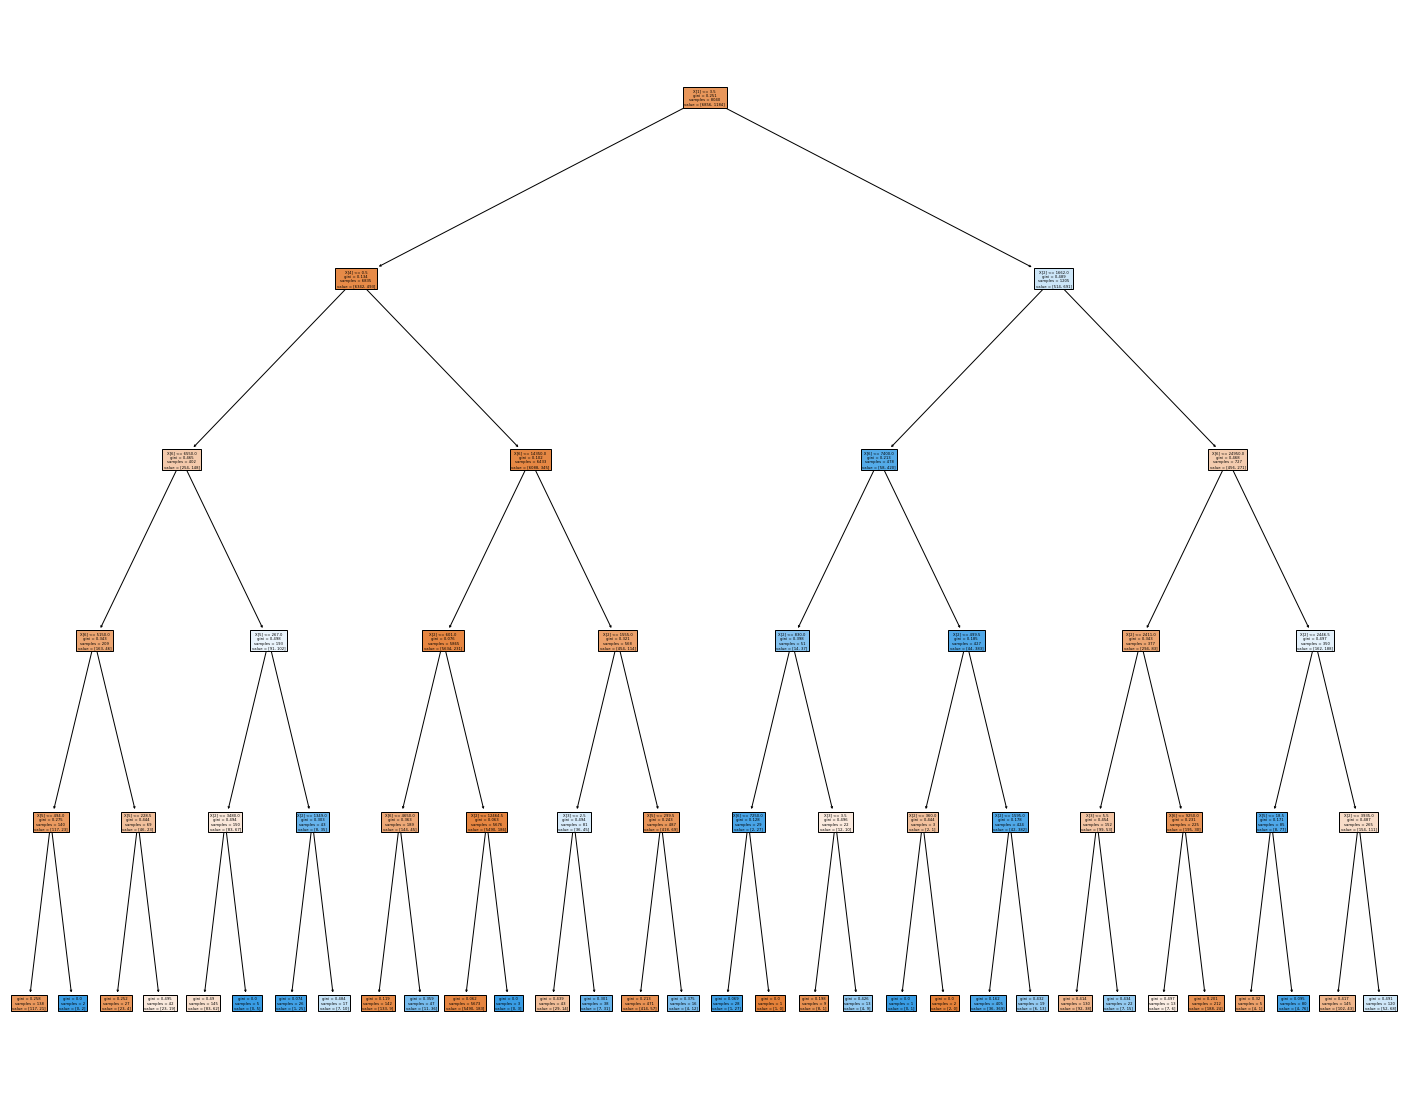

In [32]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_cls, filled=True)

In [33]:
# Predict Test-set labels
Y_cls_pred = model_cls.predict(X_cls_valid)
# Compute Test-set Accuracy
clf_acc_test_score = accuracy_score(Y_cls_valid, Y_cls_pred)
print('Accuracy = %.4f' % (clf_acc_test_score))

Accuracy = 0.9040


## Decision Tree Regressor

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
# measuring runtime
start = timeit.default_timer()
model_reg = DecisionTreeRegressor(min_samples_split=3, max_depth=5)
model_reg.fit(X_reg_train,Y_reg_train)
stop = timeit.default_timer()
reg_skl_runtime = stop - start
print('Time: ', reg_skl_runtime)
print('Sklearn Decision Tree Regressor:')
print(tree.export_text(model_reg))

Time:  0.006464600000072096
Sklearn Decision Tree Regressor:
|--- feature_3 <= 2277.50
|   |--- feature_4 <= 2.50
|   |   |--- feature_3 <= 1194.50
|   |   |   |--- feature_6 <= 76.50
|   |   |   |   |--- feature_3 <= 456.00
|   |   |   |   |   |--- value: [2675.00]
|   |   |   |   |--- feature_3 >  456.00
|   |   |   |   |   |--- value: [8481.84]
|   |   |   |--- feature_6 >  76.50
|   |   |   |   |--- feature_3 <= 701.00
|   |   |   |   |   |--- value: [3190.85]
|   |   |   |   |--- feature_3 >  701.00
|   |   |   |   |   |--- value: [4932.15]
|   |   |--- feature_3 >  1194.50
|   |   |   |--- feature_3 <= 1684.00
|   |   |   |   |--- feature_6 <= 170.50
|   |   |   |   |   |--- value: [8987.06]
|   |   |   |   |--- feature_6 >  170.50
|   |   |   |   |   |--- value: [6670.80]
|   |   |   |--- feature_3 >  1684.00
|   |   |   |   |--- feature_6 <= 125.50
|   |   |   |   |   |--- value: [19248.33]
|   |   |   |   |--- feature_6 >  125.50
|   |   |   |   |   |--- value: [11118.98]
|   

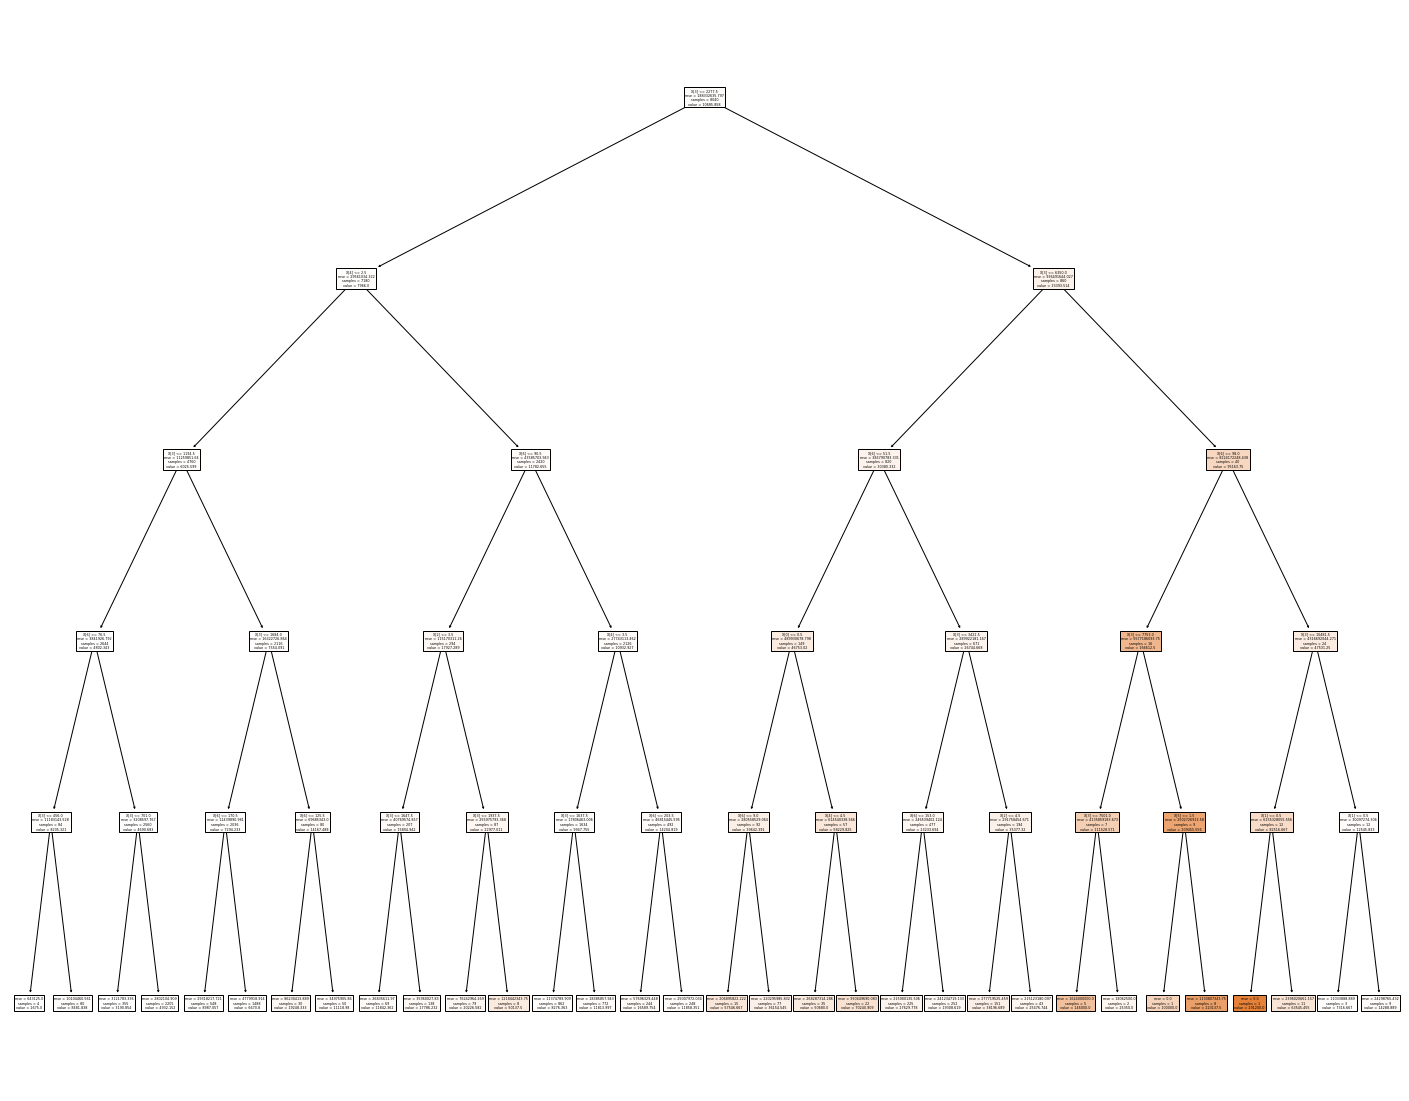

In [35]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_reg, filled=True)

In [36]:
# Predict Test-set labels
Y_reg_pred = model_reg.predict(X_reg_valid)
# Compute Test-set MSE
rgs_acc_test_score = MSE(Y_reg_valid, Y_reg_pred)
print('MSE = %.2f' % (rgs_acc_test_score))

MSE = 47702470.00


## AdaBoost Classifier

In [61]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
# measuring runtime
start = timeit.default_timer()
model_ada = AdaBoostClassifier()
model_ada.fit(X_cls_train,Y_cls_train)
stop = timeit.default_timer()
adbt_skl_runtime = stop - start
print('Time: ', adbt_skl_runtime)

Time:  0.18205369999986942


C:\Users\rotem\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [59]:
# Predict Test-set labels
Y_cls_pred = model_ada.predict(X_cls_valid)
# Compute Test-set Accuracy
adbt_acc_test_score =  accuracy_score(Y_cls_valid, Y_cls_pred)
print('Accuracy = %.4f' % (adbt_acc_test_score))

Accuracy = 0.9050


In [39]:
from tabulate import tabulate

In [40]:
#create table of Implemenataion Scores
Implemenataion = [["Decission Tree", Classifier_test_score,clf_imp_runtime], 
        ["Regression Tree", Regressor_test_score,reg_imp_runtime], 
        ["AdaBoost", AdaBoost_test_score,adbt_imp_runtime]]
  
#define header names
col_names = ["Algorithm","Score (Test)","RunTime (Sec)",]

print ("--------------Implemenataion Test Scores--------------")
  
#display table
print(tabulate(Implemenataion, headers=col_names, tablefmt="fancy_grid"))


#create table of SKLearn Scores
sklearn_score = [["Decission Tree", clf_acc_test_score,clf_skl_runtime], 
        ["Regression Tree", rgs_acc_test_score,reg_skl_runtime], 
        ["AdaBoost", adbt_acc_test_score,adbt_skl_runtime]]
  
#define header names
col_names = ["Algorithm","Score (Test)","RunTime (Sec)",]

print ("------------------SKLearn Test Scores-----------------")
  
#display table
print(tabulate(sklearn_score, headers=col_names, tablefmt="fancy_grid"))

--------------Implemenataion Test Scores--------------
╒═════════════════╤════════════════╤═════════════════╕
│ Algorithm       │   Score (Test) │   RunTime (Sec) │
╞═════════════════╪════════════════╪═════════════════╡
│ Decission Tree  │       0.909236 │        88.9641  │
├─────────────────┼────────────────┼─────────────────┤
│ Regression Tree │    8197.62     │        39.978   │
├─────────────────┼────────────────┼─────────────────┤
│ AdaBoost        │       0.850249 │         3.60619 │
╘═════════════════╧════════════════╧═════════════════╛
------------------SKLearn Test Scores-----------------
╒═════════════════╤════════════════╤═════════════════╕
│ Algorithm       │   Score (Test) │   RunTime (Sec) │
╞═════════════════╪════════════════╪═════════════════╡
│ Decission Tree  │    0.90398     │       0.008083  │
├─────────────────┼────────────────┼─────────────────┤
│ Regression Tree │    4.77025e+07 │       0.0064646 │
├─────────────────┼────────────────┼─────────────────┤
│ AdaBoost

Our Decision Trees are very similar to the SKLEARN Decision Trees.
We are more accurate in classification and regression
However, our implementations isn't efficiency in terms of runtime than the SKLEARN models.